In [313]:
!uv add torch
!uv add matplotlib

Resolved 128 packages in 35ms
Audited 107 packages in 24ms
Resolved 128 packages in 5ms
Audited 107 packages in 2ms


In [314]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [315]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [316]:
sdf = torch.tensor(np.load("./data/distance_field.npy"), dtype=torch.float).to(device)
uv = torch.tensor(np.load("./data/uv.npy"))
vv = torch.tensor(np.load("./data/vv.npy"))
#plt.imshow(sdf)

# Here define the model of our neural network

In [317]:
start_pos = torch.tensor([5,5]).to(device)#np.random.rand(2) * 40, dtype=torch.float).to(device)
end_pos = torch.tensor([20,35]).to(device)#np.random.rand(2) * 40, dtype=torch.float).to(device)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = nn.Linear(1, 32)
        # change activ fun. more smooth
        self.dense2 = nn.Linear(32, 32)
        # self.dense3 = nn.Linear(32, 32)
        self.dense4 = nn.Linear(32, 2)
        self.sigmoid = nn.Sigmoid()


    def forward(self, t):
        x = torch.sin(self.dense1(t))
        x = torch.sin(self.dense2(x))
        #x = torch.sin(self.dense3(x))
        x = self.dense4(x)
        return (1-t)*start_pos + t*end_pos + t * (1-t)*x*40

model = PINN().to(device)
print(model)


PINN(
  (dense1): Linear(in_features=1, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


# Next we define the loss function

In [318]:
class PathLoss(nn.Module):
    def __init__(self):
        super(PathLoss, self).__init__()

    def forward(self, path, sdf):
        # path: (100, 2), sdf: (H, W) tensor
        H, W = sdf.shape

        # normalize path coords to [-1, 1] as required by grid_sample
        grid = path.clone()
        grid[:, 0] = (grid[:, 0] / (W - 1)) * 2 - 1  # x
        grid[:, 1] = (grid[:, 1] / (H - 1)) * 2 - 1  # y

        # grid_sample expects (N, C, H, W) and grid (N, H, W, 2)
        sdf_input = sdf.unsqueeze(0).unsqueeze(0)          # (1, 1, H, W)
        grid_input = grid.unsqueeze(0).unsqueeze(0)        # (1, 1, 100, 2)

        sdf_vals = F.grid_sample(sdf_input.cpu(), grid_input.cpu(),
                                  align_corners=True,
                                  padding_mode='zeros', mode='bicubic').to(path.device)  # (1, 1, 1, 100)
        sdf_vals = sdf_vals.squeeze()                      # (100,)
        loss = (1 / (sdf_vals**2 + 1e-5)).sum()
        return loss
loss = PathLoss().to(device)

# Training Function

In [319]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
def train(model, optimizer, device, sdf, loss_fn):
    training_steps = 1000
    model.train()
    for i in range(training_steps):
        optimizer.zero_grad()
        path_list = []

        for t in range(0, 100):
            t_tensor = torch.tensor(t * 1e-2, dtype=torch.float32, device=device)
            path_list.append(model(t_tensor.unsqueeze(0)))

        path = torch.stack(path_list)
        loss = loss_fn(path, sdf)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            loss = loss.item()
            print(f"loss: {loss:>7f}")
            # plt.plot(path_list[0].cpu().detach().numpy(), path_list[1].cpu().detach().numpy(), label="path")


# Run Training

In [320]:
epochs = 3
for epoch in range(epochs):
    train(model, optimizer, device, sdf, loss)

loss: 526650.500000
loss: 2789.152100
loss: 4402.459961
loss: 3525.837891
loss: 3187.706543
loss: 3110.142090
loss: 3060.040039
loss: 3011.313965
loss: 2963.278320
loss: 2916.521973
loss: 2872.518066
loss: 2830.450928
loss: 2790.272461
loss: 2751.836426
loss: 2715.073975
loss: 2679.822266
loss: 2645.975098
loss: 2613.378662
loss: 2581.956543
loss: 2551.603271
loss: 2522.196777
loss: 2493.683594
loss: 2465.968262
loss: 2438.958984
loss: 2412.614746
loss: 2386.839844
loss: 2361.586426
loss: 2336.809082
loss: 2312.416016
loss: 2288.399658


# Visualize path

In [321]:
#print(start_pos)
#print(end_pos)
path_x = []
path_y = []
for t in range(0, 100):
            model.eval()
            torch.no_grad()
            t_tensor = torch.tensor(t * 1e-2, dtype=torch.float32, device=device)
            #path_list.append(model(t_tensor.unsqueeze(0)))
            point = model.forward(t_tensor.unsqueeze(0))
            #print(model.forward(t_tensor.unsqueeze(0)))
            path_x.append(point[0].cpu().detach().numpy())
            path_y.append(point[1].cpu().detach().numpy())

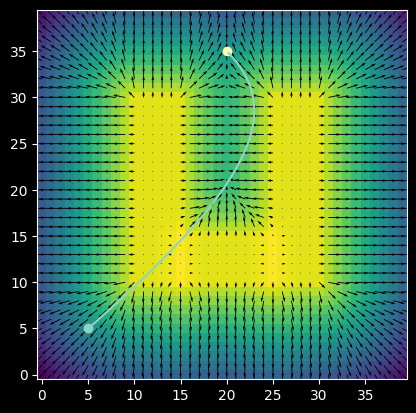

In [328]:
grad_y, grad_x = np.gradient(sdf.cpu().detach().numpy())
plt.quiver(-grad_x, -grad_y, scale=30)
plt.plot(path_x, path_y)
plt.imshow(sdf.cpu().detach().numpy(), origin="lower")
plt.scatter(*start_pos.cpu().detach().numpy())
plt.scatter(*end_pos.cpu().detach().numpy())